# Dataset available at kaggle
https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

## Project Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torch.utils.data import DataLoader
import timm  
from torch import nn
from tqdm import tqdm 

# Configurations

In [2]:
TRAIN_IMG_FOLDER_PATH = 'Facial-Expression-Dataset/train'
VALID_IMG_FOLDER_PATH = 'Facial-Expression-Dataset/validation/'

LR = .001
BATCH_SIZE = 32
EPOCHS = 15

DEVICE = 'cpu'


MODEL_NAME = 'efficientnet_b0'


## Dataset loading and data augmentation

In [3]:
train_augs = T.Compose([  # compose several transformations sequentially together
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation(degrees= (-20, +20)),
    T.ToTensor() # convert PIL/numpy -> PyTorch Tensor , normalizing the pixel intesity [0, 255] to [0,1]
                        ])

valid_augs = T.Compose([
    T.ToTensor()
])


In [4]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform = train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform = valid_augs)

In [5]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [6]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, '0')

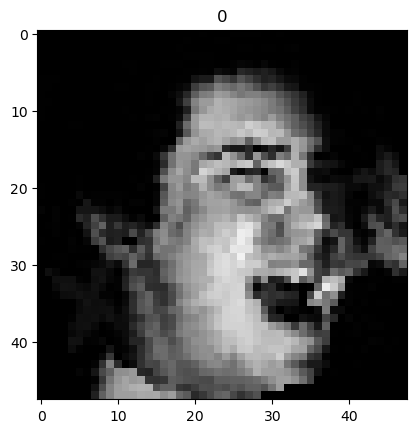

In [8]:
idx = 40 # Arbitrary index
image, label = trainset[idx]
plt.imshow(image.permute(1, 2, 0))
plt.title(label)

## Load Dataset into Batches

In [7]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle= True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)


In [8]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")  # len(trainset) / batch_size
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [9]:
for images, labels in trainloader:
  break ; # take the first batch only

print(f"One image batch shape : {images.shape}") # [batchsize, channels, height, wedith]
print(f"One label batch shape : {labels.shape}")


One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


# Create Model

In [10]:
class FaceModel(nn.Module):
  def __init__(self):
    super(FaceModel, self).__init__()

    self.eff_net = timm.create_model( MODEL_NAME, pretrained= True , num_classes = 7)

  def forward(self, images, labels = None):
    logits = self.eff_net(images)

    if labels != None:
      loss = nn.CrossEntropyLoss()(logits, labels)
      return logits, loss

    return logits

In [11]:
model = FaceModel()
model.to(DEVICE);

# Create Train and Eval Function

In [12]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [15]:
def train_fn(model, dataloader, optimizer, current_epo):

  # set model to train mode
  model.train()

  # keep track of the total loss and accuracy over all batches
  total_loss = 0.0
  total_acc = 0.0

  # provide a visual feedback on the training process
  tk = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(current_epo +1) + "/" + str(EPOCHS))

  # iterate over dataloader
  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    optimizer.zero_grad() # clears the gradients for all optimized tensors
      
    # perform a forward pass through the model to obtain the logits and compute the loss using provided images.
    logits, loss = model(images, labels)

    #compute gradient
    loss.backward()

    # update the model parameter based on the computed gradient
    optimizer.step()

    # update loss : addes the current batch loss to the total loss
    total_loss += loss.item()

    # update accuracy
    total_acc += multiclass_accuracy(logits, labels)

    # update progress bar for the current loss and  and accuracy informatino for the batch
    tk.set_postfix({'loss' : '%6f' %float(total_loss / (t+1)), 'acc' : '%6f' %float(total_acc / (t+1))})

  # return average loss and accuracy
  return total_loss / len(dataloader), total_acc / len(dataloader)


In [16]:
def eval_fn(model, dataloader,  current_epo):
  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "EPOCH" + "[VALID]" + str(current_epo +1) + "/" + str(EPOCHS))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    logits, loss = model(images, labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : '%6f' %float(total_loss / (t+1)), 'acc' : '%6f' %float(total_acc / (t+1))})

  return total_loss / len(dataloader), total_acc / len(dataloader)

# Create Training Loop

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [27]:
best_valid_loss = np.Inf  # set best valid to + infinity

for i in range(EPOCHS):
  train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
  valid_loss, valid_acc = eval_fn(model, validloader, i)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best-weights.pt') # save the current valid loss 
    print("SAVED-BEST-WEIGHTS")
    best_valid_loss = valid_loss  # update the best valid


EPOCH[VALID]1/15: 100%|██████████| 221/221 [00:06<00:00, 32.42it/s, loss=1.616050, acc=0.489286]


SAVED-BEST-WEIGHTS


EPOCH[VALID]2/15: 100%|██████████| 221/221 [00:06<00:00, 33.24it/s, loss=1.197593, acc=0.547185]


SAVED-BEST-WEIGHTS


EPOCH[VALID]3/15: 100%|██████████| 221/221 [00:06<00:00, 31.74it/s, loss=1.148980, acc=0.569527]


SAVED-BEST-WEIGHTS


EPOCH[VALID]4/15: 100%|██████████| 221/221 [00:06<00:00, 35.77it/s, loss=1.109511, acc=0.586528]


SAVED-BEST-WEIGHTS


EPOCH[VALID]5/15: 100%|██████████| 221/221 [00:06<00:00, 32.13it/s, loss=1.056870, acc=0.601973]


SAVED-BEST-WEIGHTS


EPOCH[VALID]6/15: 100%|██████████| 221/221 [00:06<00:00, 32.14it/s, loss=1.029614, acc=0.607270]


SAVED-BEST-WEIGHTS


EPOCH[VALID]8/15: 100%|██████████| 221/221 [00:06<00:00, 35.62it/s, loss=1.024220, acc=0.616722]


SAVED-BEST-WEIGHTS


EPOCH[VALID]9/15: 100%|██████████| 221/221 [00:06<00:00, 31.98it/s, loss=1.007906, acc=0.629405]


SAVED-BEST-WEIGHTS


EPOCH[VALID]10/15: 100%|██████████| 221/221 [00:06<00:00, 34.36it/s, loss=0.999172, acc=0.626686]


SAVED-BEST-WEIGHTS


EPOCH[VALID]11/15: 100%|██████████| 221/221 [00:06<00:00, 36.00it/s, loss=0.987602, acc=0.641805]


SAVED-BEST-WEIGHTS


EPOCH[VALID]15/15: 100%|██████████| 221/221 [00:06<00:00, 33.43it/s, loss=0.956868, acc=0.649517]


SAVED-BEST-WEIGHTS


# Inference

In [18]:
def view_classify(img, ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [21]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
from PIL import Image
# Define a function to preprocess the input image
def preprocess_image(image_path):
    transform = T.Compose([
        T.Resize((48, 48)),
        T.ToTensor(),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

def preprocess_image_vid(image):
    transform = T.Compose([
        T.Resize((48, 48)),
        T.ToTensor(),
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Define a function to perform inference
# Define a function to perform inference
def predict_emotion(model, image):
    model.eval() #sets the model for evaluation mode
    image = image.to(DEVICE) # move image to device
    with torch.no_grad():  # Disable calculating gradient(training the model)
        output = model(image) #pass the image to obtain the logits
        probabilities = torch.softmax(output, dim=1) # compute the probabilities using softmax
        predicted_class = torch.argmax(probabilities).item() # find the index with the max probabilitites
    return predicted_class, probabilities

# Load the model
model = FaceModel()
model.load_state_dict(torch.load('best-weights.pt'))  # load pre-trained model
model.to(DEVICE)

# test 
image, label = validset[5000]
image.unsqueeze_(0)
predicted_class, probabilities = predict_emotion(model, image)
print(f"Predicted emotion class: is [{classes[predicted_class]}] And The Ground Truth Label is  [{classes[label]}]")

Predicted emotion class: is [neutral] And The Ground Truth Label is  [neutral]


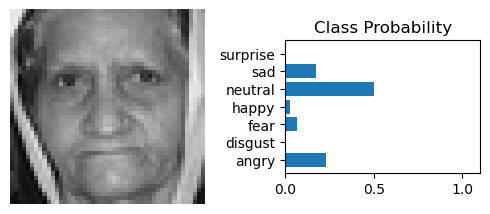

In [22]:
view_classify(image.squeeze(), probabilities)

In [23]:
img_path = 'surprise.jpg'
label = 'surprise'
image = preprocess_image(img_path)
predicted_class, probabilities = predict_emotion(model, image)
print(classes[predicted_class]) 

surprise


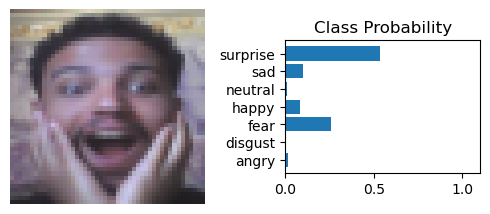

In [24]:
view_classify(image.squeeze(), probabilities)

## Intergrate With openCv

In [33]:
import cv2 as cv 
from collections import Counter

model = FaceModel()
model.load_state_dict(torch.load('best-weights.pt'))
model.to(DEVICE)

classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

predict_list = [] 

cap = cv.VideoCapture("test2.mp4") 

while True:

    ret, frame = cap.read()
    frame = cv.resize(frame, (1366, 768))
    if not ret :
        break ; 

    face_detector = cv.CascadeClassifier("haarcascade_frontalface_default.xml") 
    num_faces = face_detector.detectMultiScale(frame, scaleFactor = 1.3, minNeighbors = 5) 

    for (x, y, w, h) in num_faces: # for every face in pic
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (0, 255, 0), 4) #Draw rectange
        roi_frame = frame[y:y + h, x:x + w] #crop face from frame
        roi_RGB_frame = cv.cvtColor(roi_frame, cv2.COLOR_BGR2RGB) # convert to 3 channel to suite the model
        cropped_img = Image.fromarray(roi_RGB_frame)  # convert to PIL to suite preprocess func

        torch_img = preprocess_image_vid(cropped_img)
        pred, prob = predict_emotion(model, torch_img)
        predict_list.append(pred)
                                         
        if len(predict_list) == 60 :
            counter = Counter(predict_list)          
            most_common_element, frequency = counter.most_common(1)[0]
            print(f"Well I Think The Clinet is {classes[most_common_element]}")
            predict_list = []
                                         
        cv2.putText(frame, classes[pred], (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    cv2.imshow('Emotion Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Well I Think The Clinet is neutral
Well I Think The Clinet is happy
Well I Think The Clinet is happy
Well I Think The Clinet is happy
Well I Think The Clinet is happy
Well I Think The Clinet is neutral
Well I Think The Clinet is neutral
